In [15]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
# torch.cuda.device_count()

Running on the GPU


In [16]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader,TensorDataset
import pandas as pd
import numpy as np

Data = pd.read_csv('kuairand_sequence.csv',index_col=0)
max_length = 100
num_user = len(Data['user_id'].unique())
state_feature = len(Data.columns) - 1
action_feature = 3

uid = Data['user_id'].unique()
uid
print(uid.shape)
print(state_feature)

(6051,)
27


In [17]:
State = np.zeros(((num_user,max_length,state_feature)))
Action = np.zeros((num_user,max_length,action_feature))
Click = np.zeros((num_user,max_length))

j = 0
for i in uid:
    state_sequence = np.array(Data[Data['user_id']==i])[:-1]
    # state_sequence = np.array(data[data['user_id']==i].drop(['short','mid','long'],axis=1))
    action_sequence = np.array(Data[Data['user_id']==i][['short','mid','long']])[1:]
    click_sequence = np.array(Data[Data['user_id']==i]['is_click'])[1:]
    # action_sequence = np.array(data[data['user_id']==i][['short','mid','long']])
    # print(action_sequence)
    state = np.pad(state_sequence,((0,max_length-len(state_sequence)),(0,0)))[:,1:]
    action = np.pad(action_sequence,((0,max_length-len(action_sequence)),(0,0)))
    click = np.pad(click_sequence,((0,max_length-len(click_sequence))))
    # print(click)
    State[j] = state
    Action[j] = action
    Click[j] = click
    j += 1
print(len(State))
print(len(Action))
print(len(Click))
print(Click.shape)

6051
6051
6051
(6051, 100)


In [18]:
length = 2
max_number_traj = 40000

number_traj = 0
def Select_trajectory(X,Y,Z,number_traj):
    Select_states = []
    Select_actions = []
    Select_clicks = []
    # for s in range(number_traj):
    while True:
        i = random.randint(0,len(X)-1)
        select_state = X[i]
        select_action = Y[i]
        select_click = Z[i]
        # print(select_state)
        # print(select_action)
        for k in range(0,max_length):
            # print(select_episode[k])
            if select_state[k].any() == 0:
                max_episode_length = k
                break
        # print(k)
        # print(max_episode_length)
        if max_episode_length >= length + 1:
            j = random.randint(0,max_episode_length-length-1)
            select_state = select_state[j:j+length]
            select_action = select_action[j:j+length]
            select_click = select_click[j:j+length]
            Select_states.append(select_state)
            Select_actions.append(select_action)
            Select_clicks.append(select_click)
            number_traj += 1
        # print(select_trajectory)
        if number_traj == max_number_traj:
            break
    return np.array(Select_states),np.array(Select_actions),np.array(Select_clicks)

X , Y , Z = Select_trajectory(State,Action,Click,number_traj)
print(len(X))
print(X[0])
print(Y[0])
print(Z[0])

40000
[[0.86956522 0.68844285 0.         0.         0.00159089 1.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.5        0.63265306 0.25510204 0.21428571 0.         0.20512821
  0.58278146 0.66666667 0.5       ]
 [0.7826087  0.74554684 0.         0.         0.00106976 0.
  1.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.5        0.63265306 0.25510204 0.21428571 0.         0.20512821
  0.58278146 0.66666667 0.5       ]]
[[0. 1. 0.]
 [1. 0. 0.]]
[0. 0.]


In [19]:
np.random.seed(2023)
per = np.random.permutation(X.shape[0])
# print(per)
X = X[per]
Y = Y[per]
Z = Z[per]

In [20]:
def split_data(State, Action, Reward, timestep, input_size, output_size):

    train_size = int(np.round(0.8 * X.shape[0]))
    print(train_size)
    
    x_train = State[: train_size, :].reshape(-1, timestep,input_size)
    y_train = Action[: train_size].reshape(-1,timestep, output_size)
    z_train = Reward[: train_size].reshape(-1,timestep, 1)

    x_test = State[train_size:, :].reshape(-1, timestep,input_size)
    y_test = Action[train_size:].reshape(-1,timestep, output_size)
    z_test = Reward[train_size:].reshape(-1,timestep, 1)

    return [x_train, y_train, z_train, x_test, y_test, z_test]

X1,Y1,Z1,X2,Y2,Z2=split_data(X,Y,Z,length,state_feature,action_feature)
X1,Y1=torch.from_numpy(X1).to(torch.float32).to(device),torch.from_numpy(Y1).to(torch.float32).to(device)
X2,Y2=torch.from_numpy(X2).to(torch.float32).to(device),torch.from_numpy(Y2).to(torch.float32).to(device)
Z1,Z2=torch.from_numpy(Z1).to(torch.float32).to(device),torch.from_numpy(Z2).to(torch.float32).to(device)
train_ids = TensorDataset(X1,Y1,Z1)
test_ids = TensorDataset(X2,Y2,Z2)
print(test_ids[0])

32000
(tensor([[1.0000, 0.6958, 0.0000, 0.0000, 0.0016, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.6667, 0.2041, 0.3755, 0.2143, 0.5000, 0.0684, 0.0795, 0.6667, 1.0000],
        [0.3043, 0.7173, 0.0000, 0.0000, 0.0010, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.6667, 0.2041, 0.3755, 0.2143, 0.5000, 0.0684, 0.0795, 0.6667, 1.0000]],
       device='cuda:0'), tensor([[1., 0., 0.],
        [0., 0., 1.]], device='cuda:0'), tensor([[0.],
        [0.]], device='cuda:0'))


In [21]:
class IQL(torch.nn.Module):
    def __init__(self,feature_size, NUM_STATES,NUM_ACTIONS):
        super(IQL, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, feature_size)
        self.fc1.weight.data.normal_(0,0.1)
        self.fc2 = nn.Linear(feature_size,feature_size)
        self.fc2.weight.data.normal_(0,0.1)
        self.out = nn.Linear(feature_size,NUM_ACTIONS)
        self.out.weight.data.normal_(0,0.1)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action_value = self.out(x)
        return action_value

In [22]:
Batchsize = 512
# data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=True)
data_train_loader = DataLoader(dataset=train_ids, batch_size=Batchsize, shuffle=False)
data_test_loader = DataLoader(dataset=test_ids, batch_size=1, shuffle=False,drop_last=False)

In [23]:
def Expectlie_loss(X,tao):

    y = torch.clone(X)
    # print(y)
    y[y>=0] = 0
    y[y<0] = 1

    return torch.mean((torch.abs(tao-y))*X**2)

A = torch.squeeze(torch.normal(0,1,(1,100)))
# print(A)
Expectlie_loss(A, 0.9)

tensor(0.5081)

Loss of episode 0 = 0.38075334
Loss of episode 1 = 0.2361286
Loss of episode 2 = 0.23301417
Loss of episode 3 = 0.23129955
Loss of episode 4 = 0.22994366
Loss of episode 5 = 0.22856091
Loss of episode 6 = 0.22738588
Loss of episode 7 = 0.22637397
Loss of episode 8 = 0.22535719
Loss of episode 9 = 0.22438799
Loss of episode 10 = 0.22340058
Loss of episode 11 = 0.22249772
Loss of episode 12 = 0.22168902
Loss of episode 13 = 0.22087272
Loss of episode 14 = 0.22007206
Loss of episode 15 = 0.21930425
Loss of episode 16 = 0.21843909
Loss of episode 17 = 0.21756363
Loss of episode 18 = 0.21672519
Loss of episode 19 = 0.21581772
Loss of episode 20 = 0.21490398
Loss of episode 21 = 0.21390693
Loss of episode 22 = 0.21290861
Loss of episode 23 = 0.21200778
Loss of episode 24 = 0.21099098
Loss of episode 25 = 0.20992635
Loss of episode 26 = 0.20887819
Loss of episode 27 = 0.20795435
Loss of episode 28 = 0.20697418
Loss of episode 29 = 0.20612997
Loss of episode 30 = 0.20508608
Loss of episode 31 

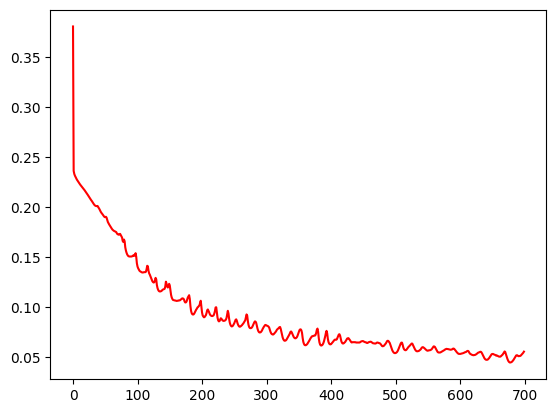

In [24]:
Net = IQL(512,27,3).to(device)
num_epoch = 800
# optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
optimizer = torch.optim.Adam(Net.parameters(),lr=0.001)
MSE_loss = torch.nn.MSELoss() 
# loss_func = torch.nn.CrossEntropyLoss() 
CE_loss = torch.nn.CrossEntropyLoss()
Loss=[]
for t in range(num_epoch):
    aver_loss = 0
    Net.train()
    for batch, data in enumerate(data_train_loader):
    # for x,y in data_train_loader:
        x, y, z = data
        # print(y.shape)
        Value = Net(x)
        # print(Value[0])
        # print(torch.max(Value,dim=2)[0])
        # print(Value.shape)
        Action_Value = torch.sum(torch.mul(Value, y),dim=-1)
        Reward = torch.squeeze(z)
        # print(Action_Value)
        # print(Reward.shapQ_valuee)

        Target = Reward[:,0] + Action_Value[:,1]
        Q_value = Action_Value[:,0]
        # loss = loss_func(Q_value,Target) - 0.001 * torch.mean(Q_value)
        # print((Q_value-Target)**2)
        # print(Expectlie_loss(Q_value-Target,0.9))

        loss = MSE_loss(Value,y) + 0.3 * Expectlie_loss(Q_value-Target, 0.9) 
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()  
        aver_loss += loss
    aver_loss /= batch
    aver_loss=aver_loss.cpu().detach().numpy()
    print('Loss of episode %s ='%t,aver_loss)
    Loss.append(aver_loss)
    # Loss.append(loss.detach().numpy())
plt.plot(Loss,color='r')

In [25]:
from sklearn.metrics import roc_curve, auc


Loss=[]
Truth = []
Pred = []
aver_loss = 0
total_acc = 0
total_ctr = 0
total_auc = 0
Entropy = 0
num = 0

# Click_pred = np.zeros((int(0.2*max_number_traj),length))
# Click_true = np.zeros((int(0.2*max_number_traj),length))
Net.eval()
for batch, data in enumerate(data_test_loader):
# for batch, data in enumerate(data_full_loader):
# for x,y in data_train_loader:
    x, y, z = data
    Q_value = Net(x)
    # print(Q_value)
    # print(y)
    a = torch.argmax(Q_value[0][0],dim = 0).cpu().data.numpy()
    b = torch.argmax(y[0][0],dim = 0).cpu().data.numpy()
    # # print(test)
    # a = torch.argmax(test,dim = 2).cpu().data.numpy().T[0]
    # b = torch.argmax(y,dim = 2).cpu().data.numpy()[0]
    print('-----------')
    print('pred =',a)
    print('true =',b)
    aver_acc = a==b
    total_acc += aver_acc

    # aver_ctr = sum(click_pred==click_true)/length
    # total_ctr += aver_ctr


# fpr, tpr, thresholds = roc_curve(Click_true.reshape(-1), Click_pred.reshape(-1),pos_label=1)
# total_auc = auc(fpr, tpr)
# print('CTR AUC =', total_auc)
print('Action acc =', total_acc/(0.2*max_number_traj))
# print('CTR acc=', total_ctr/(0.2*max_number_traj))
# print('Entropy = ', Entropy/(0.2*max_number_traj))


-----------
pred = 0
true = 0
-----------
pred = 2
true = 2
-----------
pred = 0
true = 0
-----------
pred = 2
true = 2
-----------
pred = 1
true = 1
-----------
pred = 0
true = 0
-----------
pred = 1
true = 1
-----------
pred = 2
true = 2
-----------
pred = 0
true = 1
-----------
pred = 0
true = 0
-----------
pred = 1
true = 1
-----------
pred = 0
true = 0
-----------
pred = 1
true = 1
-----------
pred = 1
true = 1
-----------
pred = 0
true = 1
-----------
pred = 0
true = 1
-----------
pred = 1
true = 1
-----------
pred = 0
true = 0
-----------
pred = 1
true = 0
-----------
pred = 0
true = 0
-----------
pred = 2
true = 2
-----------
pred = 1
true = 1
-----------
pred = 1
true = 1
-----------
pred = 1
true = 1
-----------
pred = 0
true = 0
-----------
pred = 1
true = 2
-----------
pred = 2
true = 0
-----------
pred = 0
true = 1
-----------
pred = 1
true = 2
-----------
pred = 1
true = 2
-----------
pred = 1
true = 1
-----------
pred = 1
true = 0
-----------
pred = 1
true = 1
----------

In [26]:
from sklearn.metrics import precision_score, roc_curve, auc
n_classes = 3
# length = 8
aver_auc = np.zeros(n_classes)
total_precision = 0
Y_score = np.zeros(((length, int(0.2*max_number_traj), n_classes)))
# print(Y_score.shape)
Y_label = np.zeros(((length, int(0.2*max_number_traj), n_classes)))
for batch, data in enumerate(data_test_loader):
    Net.eval()
    x, y, z = data
    # print(x)
    Q_value = Net(x)
    y_score = Q_value[0].cpu().data.numpy()
    y_label = y[0].cpu().data.numpy()
    # print(batch)
    for i in range(length):
        Y_score[i][batch] = y_score[i]
        Y_label[i][batch] = y_label[i]
fpr = dict()
tpr = dict()
roc_auc = dict()
aver_auc = np.zeros(n_classes)
for t in range(length):
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_label[t][:, i], Y_score[t][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        # aver_auc[i] += auc(fpr[i], tpr[i])
        aver_auc[i] += roc_auc[i]/length
    print('step %s AUC ='%(t+1),roc_auc)
print('Average AUC =', aver_auc)
    # precision = precision_score(a,b, average="micro")
    # total_precision += precision
# aver_precesion = total_precision/batch
# print(aver_precesion)
# print(aver_auc)

step 1 AUC = {0: 0.7687024201177498, 1: 0.7585144885671837, 2: 0.7644371363075294}
step 2 AUC = {0: 0.7642695856203925, 1: 0.759657328003267, 2: 0.7650608874238378}
Average AUC = [0.766486   0.75908591 0.76474901]


In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score

aver_f1 = 0
aver_p = 0
aver_r = 0

# print(y_pred)
# print(y_true)
for i in range(length):
  y_true = np.argmax(Y_label[i],axis = 1)
  y_pred = np.argmax(Y_score[i],axis = 1)
  f1 = round(f1_score(y_true, y_pred, average='macro' ),4)
  p = round(precision_score(y_true, y_pred, average='macro'),4)
  r = round(recall_score(y_true, y_pred, average='macro'),4)
  aver_f1 += f1/length
  aver_p += p/length
  aver_r += r/length
  print('Step %s:'%(i+1),'F1 =', f1, 'Precision =', p, 'Recall =', r)
print('Aver_F1 =', round(aver_f1,4), 'Aver_Precision =', round(aver_p,4), 'Aver_Recall =', round(aver_r,4))

Step 1: F1 = 0.6239 Precision = 0.6284 Recall = 0.6237
Step 2: F1 = 0.6167 Precision = 0.6218 Recall = 0.6169
Aver_F1 = 0.6203 Aver_Precision = 0.6251 Aver_Recall = 0.6203
